<a href="https://colab.research.google.com/github/AlbionKransiqi/Car-Classification-Deep-Learning/blob/main/Deep_Learning_Models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Deep Learning

To build the model, we decided to use Convolutional Neural Networks since they are
known to be one of the most effective types of neural networks for image classification. Next, we will build different models to classify car dataset and then evaluate their
performance

**Importing necessary libraries**

In [ ]:
## basic libraries → data exploration
import numpy as np
import pandas as pd
from PIL import Image
from glob import glob
import matplotlib.pyplot as plt
import pandas as pd
from google.colab import drive

## deep learning
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras import regularizers
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, BatchNormalization, Flatten, Input, Conv1D, Conv2D, MaxPooling2D
from keras.models import Sequential
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from tensorflow.keras.applications import efficientnet

In [ ]:
## loading the data from the drive and saved files
drive.mount('/content/drive')

df_train_labels = read_csv('/content/drive/My Drive/Colab Notebooks/car_data/training_labels.csv')
df_test_labels = read_csv('/content/drive/My Drive/Colab Notebooks/car_data/testing_labels.csv')

train_car = glob("/content/drive/My Drive/Colab Notebooks/car_data/train/*/*")
test_car = glob("/content/drive/My Drive/Colab Notebooks/car_data/test/*/*")


### Data pre-processing

Given that humans took images in our dataset, there is no specific angle or order on how pictures were taken. There is high variability in images in the dataset, and working with such a dataset can be tricky. To avoid such problems, we performed data augmentation, which is a technique that increases the diversity of the dataset by applying random transformations. Also, for all images, we selected the standard size of 224x224x3.

In [ ]:
## setting up some parameters for data augmentation
img_width, img_height = 224, 224
train_samples = len(train_car)
validation_samples = len(test_car)
## there are 196 different models
n_classes = len(model_names)
batch_size = 32

In [ ]:
from keras.preprocessing.image import ImageDataGenerator

## performing augmentation on the training data
train_datagen = ImageDataGenerator(
    rescale=1. / 255,
    zoom_range=0.2,
    rotation_range = 5,
    horizontal_flip=True)

test_datagen = ImageDataGenerator(rescale=1. / 255)

In [ ]:
## getting the path to the data
train_path = "/content/drive/My Drive/Colab Notebooks/car_data/train/"
test_path = "/content/drive/My Drive/Colab Notebooks/car_data/test/"

In [ ]:
## converting data to a tf.data.Dataset object
train_generator = train_datagen.flow_from_directory(
    train_path,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical')

validation_generator = test_datagen.flow_from_directory(
    test_path,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical')

Found 8144 images belonging to 196 classes.
Found 8040 images belonging to 196 classes.


# Transfer Learning 

Transfer learning is a process where you take an existing trained model. In this project, we used three different models MobileNet V2, VGG16 and EfficientNet B1. 



## VGG16

This convolutional neural network contains 16 layers. It has achieved 92.7% top-5 test accuracy in ImageNet, which is a dataset of over 14 million images belonging to 1000 classes.

In [ ]:
## use pre-trained VGG16 model
## the model was not accepting different image sizes with imagenet weights 
vgg16_model = VGG16(include_top=False, input_shape=(224, 224, 3))

# mark loaded layers as not trainable
for layer in vgg16_model.layers:
    layer.trainable = False


x = Flatten()(vgg16_model.layers[-1].output)
x = Dense(196, activation='relu', kernel_initializer='he_uniform')(x)
output = Dense(len(train_generator.class_indices), activation='softmax')(x)

## define the new model
model = Model(inputs=vgg16_model.inputs, outputs=output)
## adding a last layers with 196 classes 

58900480/58889256 [==============================] - 2s 0us/step


In [ ]:
## compile model, define optimizer and the loss function
model.compile(loss='categorical_crossentropy', 
                  optimizer='adam',metrics=['accuracy'])

In [ ]:
history = model.fit(train_generator, steps_per_epoch=len(train_generator),
                            validation_data=validation_generator, 
                        validation_steps=len(train_generator), epochs=20)

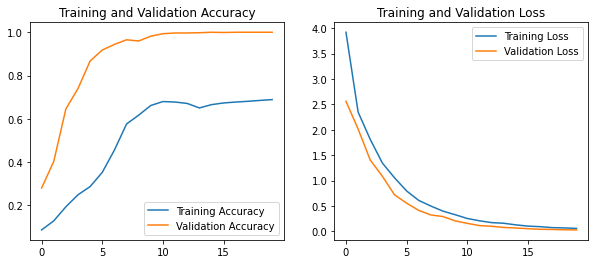

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(20)


plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### Mobile Net V2

MobileNet-v2 is a convolutional neural network that contains 53 layers. This network has been trained  on more than a million images from the ImageNet database and it can classify objects into more than a 1000 categories. This CNN has been optimized to perform well on mobile devices.


In [ ]:
## trasfer learning using mobile net
mobilenet_model = MobileNetV2(include_top=False,
                                    weights='imagenet',
                                    input_shape=(224, 224, 3))

## Change all layers to non-trainable
for layer in mobilenet_model.layers:
    layer.trainable = False

## adding some extra layers
x = GlobalAveragePooling2D()(mobilenet_model.output)
x = BatchNormalization()(x)
x = Dense(units=1024,
          activation='relu',kernel_regularizer=regularizers.l2(0.01), 
          kernel_initializer='random_uniform',
          bias_initializer='zeros')(x)

x = BatchNormalization()(x)
output = Dense(units=196, activation='softmax')(x)

## creating the extended model
model_1 = Model(inputs=mobilenet_model.input, outputs=output)

9420800/9406464 [==============================] - 0s 0us/step


In [ ]:
## in case you want to see the model summary
##model_1.summary()

In [ ]:
## compile the model, define optimizer and the loss function
opt = tensorflow.keras.optimizers.Adam(lr=0.0001)

model_1.compile(loss='categorical_crossentropy',
              optimizer=opt, metrics=['accuracy'])

In [ ]:
## train the model
history_1 = model_1.fit_generator(train_generator, 
                           steps_per_epoch=len(train_generator),
                           validation_data=validation_generator, 
                          validation_steps=len(validation_generator), epochs=20)

Epoch 1/20
255/255 [==============================] - 214s 840ms/step - loss: 15.2798 - accuracy: 0.0592 - val_loss: 13.8995 - val_accuracy: 0.1210
Epoch 2/20
255/255 [==============================] - 211s 828ms/step - loss: 12.6481 - accuracy: 0.2229 - val_loss: 12.1599 - val_accuracy: 0.2077
Epoch 3/20
255/255 [==============================] - 211s 827ms/step - loss: 10.8491 - accuracy: 0.3777 - val_loss: 10.8359 - val_accuracy: 0.2599
Epoch 4/20
255/255 [==============================] - 211s 827ms/step - loss: 9.3964 - accuracy: 0.4838 - val_loss: 9.7350 - val_accuracy: 0.3000
Epoch 5/20
255/255 [==============================] - 211s 827ms/step - loss: 8.1648 - accuracy: 0.5861 - val_loss: 8.8061 - val_accuracy: 0.3258
Epoch 6/20
255/255 [==============================] - 212s 829ms/step - loss: 7.1260 - accuracy: 0.6528 - val_loss: 8.0209 - val_accuracy: 0.3442
Epoch 7/20
255/255 [==============================] - 211s 827ms/step - loss: 6.2459 - accuracy: 0.7167 - val_loss: 7.

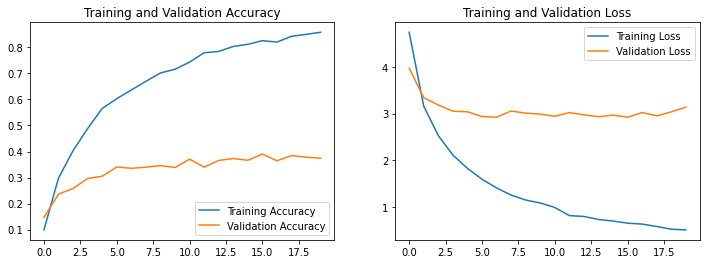

In [ ]:
acc_1 = history_1.history['accuracy']
val_acc_1 = history_1.history['val_accuracy']

loss_1 = history_1.history['loss']
val_loss_1 = history_1.history['val_loss']

epochs_range = range(20)

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc_1, label='Training Accuracy')
plt.plot(epochs_range, val_acc_1, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss_1, label='Training Loss')
plt.plot(epochs_range, val_loss_1, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## EfficientNet B1

EfficientNet is among the most efficient models Also, this network has been pre-trained on the ImageNet database, but it is considered to be one the most efficient models. In comparsion with other CNNs, EfficientNet use a method called compound scaling, which uniformly scales all dimensions of depth/width/resolution while maintaingn the balance (ref). That reduces significantly the the dimensions of the classification problems. 

In [ ]:
## loading the EfficientNetB1 model
base_model = efficientnet.EfficientNetB1(weights='imagenet', include_top=False)

## adding some extra layers
x = base_model.output
x = GlobalAveragePooling2D()(x)
predictions = Dense(196, activation='softmax')(x)
model_2 = Model(inputs=base_model.input, outputs=predictions)

## fix the feature extraction part of the model
for layer in base_model.layers:
    if isinstance(layer, BatchNormalization):
        layer.trainable = True
    else:
        layer.trainable = False


# model_2.summary()

27033600/27018416 [==============================] - 1s 0us/step


In [ ]:
## compile model, define optimizer and the loss function
model_2.compile(loss='categorical_crossentropy',
              optimizer=optimizers.Adam(lr=0.01), metrics=['accuracy'])

In [ ]:
## train the model
history_2 = model_2.fit_generator(generator=train_generator,
                    steps_per_epoch=len(train_generator) ,
                    validation_data=validation_generator,
                    validation_steps=len(validation_generator),
                    epochs=20)

Epoch 1/20
255/255 [==============================] - 206s 807ms/step - loss: 4.7295 - accuracy: 0.0905 - val_loss: 3.8548 - val_accuracy: 0.2104
Epoch 2/20
255/255 [==============================] - 202s 790ms/step - loss: 3.0157 - accuracy: 0.3692 - val_loss: 2.6637 - val_accuracy: 0.3934
Epoch 3/20
255/255 [==============================] - 201s 789ms/step - loss: 1.9686 - accuracy: 0.5624 - val_loss: 2.0400 - val_accuracy: 0.5106
Epoch 4/20
255/255 [==============================] - 201s 787ms/step - loss: 1.3963 - accuracy: 0.6795 - val_loss: 1.6762 - val_accuracy: 0.5834
Epoch 5/20
255/255 [==============================] - 202s 791ms/step - loss: 1.0631 - accuracy: 0.7491 - val_loss: 1.4870 - val_accuracy: 0.6157
Epoch 6/20
255/255 [==============================] - 201s 788ms/step - loss: 0.8484 - accuracy: 0.7978 - val_loss: 1.3790 - val_accuracy: 0.6410
Epoch 7/20
255/255 [==============================] - 201s 786ms/step - loss: 0.6741 - accuracy: 0.8426 - val_loss: 1.3045 -

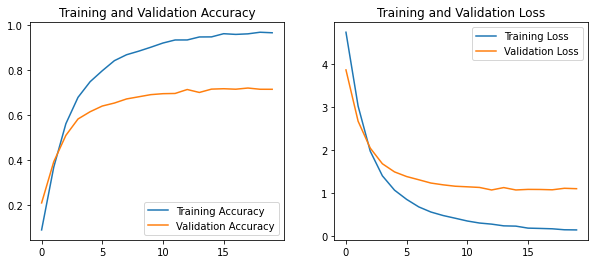

In [ ]:
acc_2 = history_2.history['accuracy']
val_acc_2 = history_2.history['val_accuracy']

loss_2 = history_2.history['loss']
val_loss_2 = history_2.history['val_loss']

epochs_range = range(20)

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc_2, label='Training Accuracy')
plt.plot(epochs_range, val_acc_2, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss_2, label='Training Loss')
plt.plot(epochs_range, val_loss_2, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### Model predictions

This function selects images from the testing datasets, inputs them in the model that we created and returns the perdiction about what car is in the image. Also, it plots the image of the car, so someone can see if the prediction is true or false. 

In [ ]:
def predict_class(model):
    '''
    This function will predict what is the next car, check whether the prediction
    was correct and lastly plot the image of the car
    '''
    image_batch, classes_batch = next(validation_generator)
    predicted_batch = model.predict(image_batch)
    for i in range(0,3):
        image = image_batch[i]
        pred = predicted_batch[i]
        the_pred = np.argmax(pred)
        predicted = model_names[the_pred]
        val_pred = max(pred)
        the_class = np.argmax(classes_batch[i])
        value = model_names[np.argmax(classes_batch[i])]
        plt.figure(i)
        isTrue = (the_pred == the_class)
        plt.title(str(isTrue) + ' class: ' + value + ' - ' +\
              'predicted: ' + predicted + ' with probability of: '\
               + str(val_pred)[:4])
        plt.imshow(image)

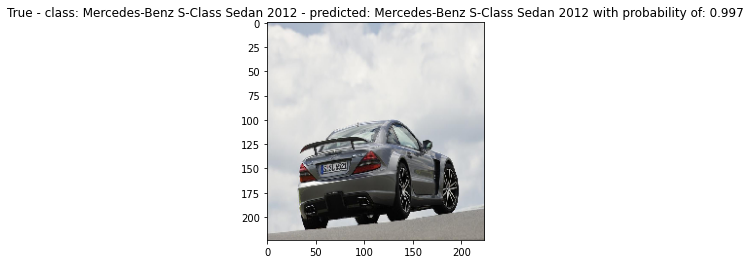

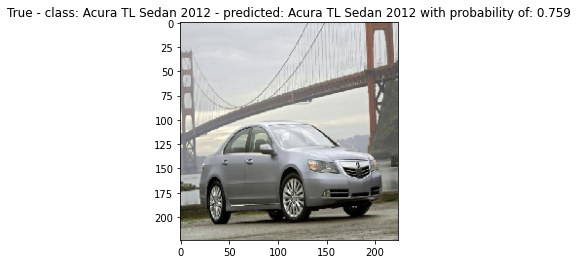

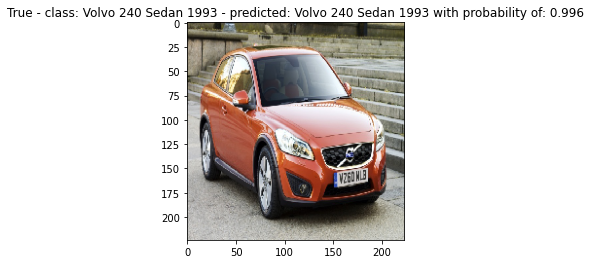

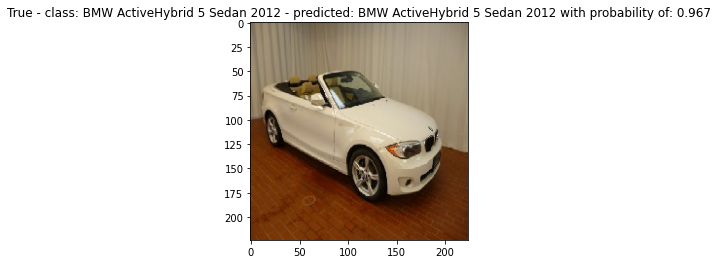

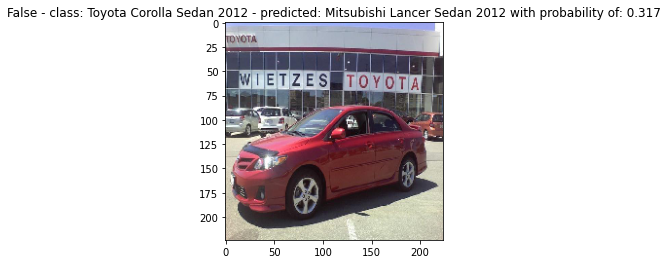

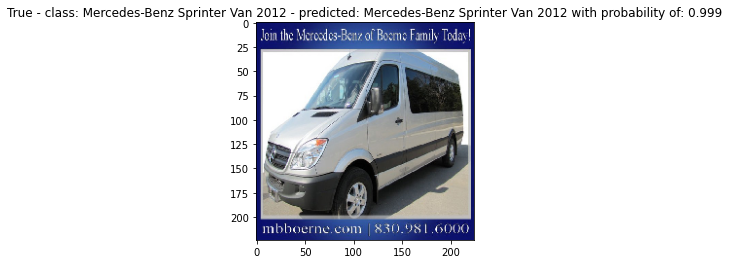

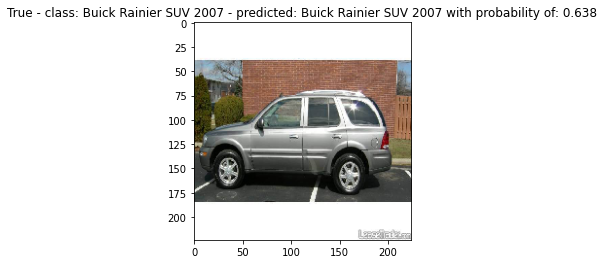

In [ ]:
## making prediction about different car models
predict_class(model_2)

## Comparsion of the networks above

Comparing the results that we obtained from different models. 

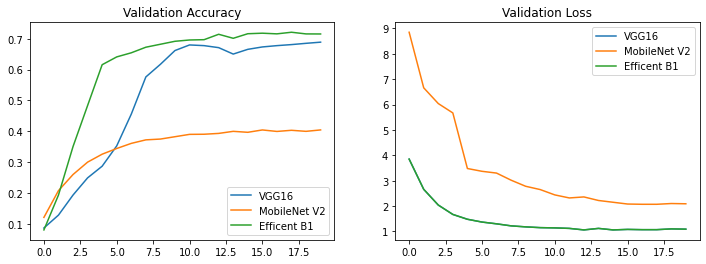

In [ ]:
epochs_range = range(20)

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)

plt.plot(epochs_range, val_acc, label='VGG16')
plt.plot(epochs_range, val_acc_1, label='MobileNet V2')
plt.plot(epochs_range, val_acc_2, label='Efficent B1')
plt.legend(loc='lower right')
plt.title('Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, val_loss, label='VGG16')
plt.plot(epochs_range, val_loss_1, label='MobileNet V2')
plt.plot(epochs_range, val_loss_2, label='Efficent B1')

plt.legend(loc='upper right')
plt.title('Validation Loss')
plt.show()